<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек-и-датасетов" data-toc-modified-id="Загрузка-библиотек-и-датасетов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек и датасетов</a></span></li><li><span><a href="#Ресемплирование-и-проверка-на-монотонность" data-toc-modified-id="Ресемплирование-и-проверка-на-монотонность-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование и проверка на монотонность</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Загрузка библиотек и датасетов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit

import time
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 12345

In [2]:
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Ресемплирование и проверка на монотонность

In [4]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
#Проверка на монотонность
df.index.is_monotonic

True

In [6]:
df.isnull().sum()

num_orders    0
dtype: int64

**Вывод**

- Исходные данные содержат 26496 ненулевых строк
- Временной промежуток данных начинается с 2018-03-01 00:00:00 и заканчивается 2018-08-31 23:00:00
- Временной интревал наблюдений составлял 10 минут до ресемплирования по одному часу (данные агрегированы с помощью суммы)
- Пропусков в данных не обнаружено
- Данные расположены в хронологическом порядке (монотонны)

Произведена замена типа данных столбца 'datetime' c object на datetime <br/>
Установлен индекс таблицы равным столбцу datetime

## Анализ

In [7]:
def draw(data, col):
    Q1 = np.quantile(data[col], 0.25, interpolation='midpoint')
    Q3 = np.quantile(data[col], 0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    
    plt.figure(figsize=(15,.5))
    sns.boxplot(data[col]).set(xlim = [Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)])
    plt.show()
    
    plt.figure(figsize=(15,3))
    sns.distplot(data[col])
    plt.show()

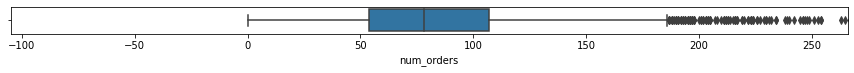

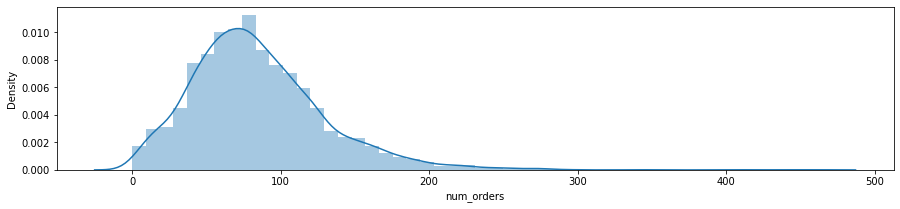

In [8]:
draw(df, 'num_orders')

In [9]:
# найдем значение квантилей
q1 = int(df['num_orders'].quantile([0.25]))
q3 = int(df['num_orders'].quantile([0.75]))
print((q1), (q3))

54 107


In [10]:
# найдем межквартильное расстояние
iqr = q3 - q1
iqr

53

In [11]:
# Найдем правый край Усов
q_moustache = q3 + 1.5*iqr
q_moustache

186.5

In [12]:
# посмотрим на выбросы в датафрейме
df[df['num_orders'] > q_moustache].tail(30)

,num_orders
datetime,
2018-08-28 00:00:00,192
2018-08-28 09:00:00,195
2018-08-28 17:00:00,211
2018-08-28 21:00:00,189
2018-08-29 00:00:00,234
2018-08-29 14:00:00,196
2018-08-29 16:00:00,220
2018-08-29 20:00:00,191
2018-08-29 23:00:00,265


In [13]:
df[df['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Судя по графику, большинство этих значений вполне естественно вписываются во временной ряд. А в список выбросов они попали из-за того что находятся в конце временного ряда, у которого есть положительный тренд. Поэтому принято решение не удалять выбросы.

Разложим временной ряд на тренд и сезонную составляющие с помощью функции

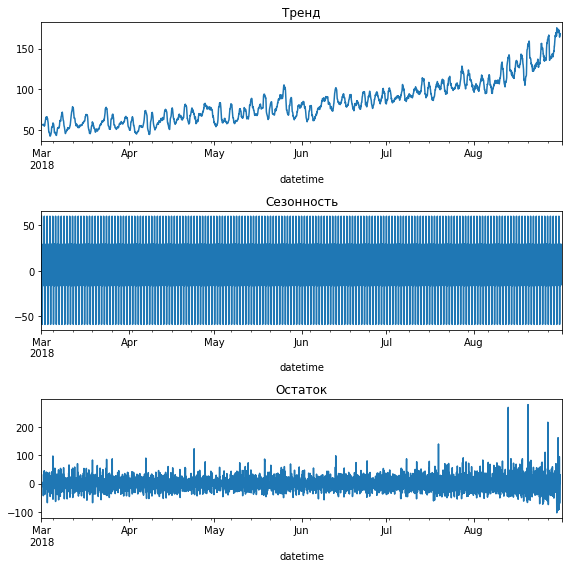

In [14]:
decomposed = seasonal_decompose(df)
 
plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

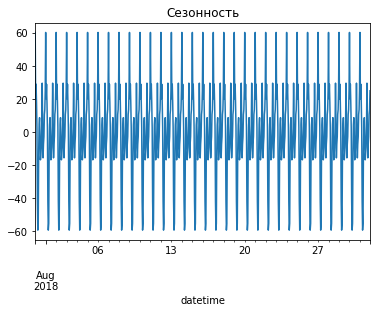

In [15]:
decomposed.seasonal['2018-07-31':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

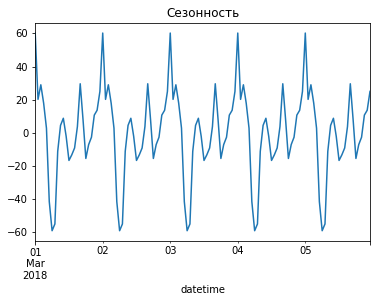

In [16]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

Проверим, к какому типу принадлежит наш временной ряд.

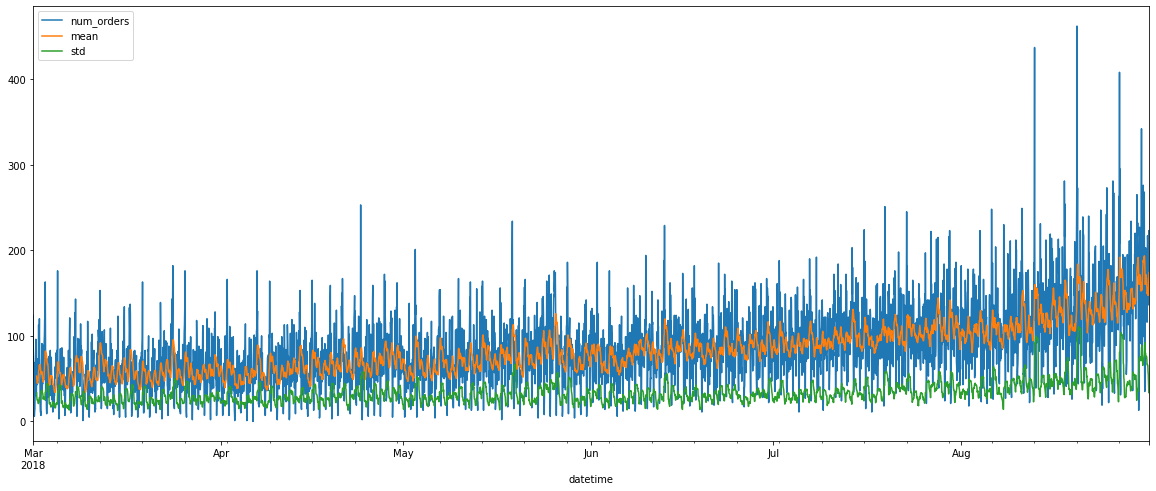

In [17]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(20,8));

Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе.

In [18]:
df = df.drop(['mean','std'], axis=1)

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.

Проведем ресемплинг, сгруппируем данные по дням и найдем скользящее среднее, чтобы оценить общую динамику изменений количества заказов

In [19]:
df_new = df.copy()
df_new = df_new.resample('1D').sum()
df_new['rolling_mean'] = df_new['num_orders'].rolling(5).mean()
df_new = df_new.dropna()

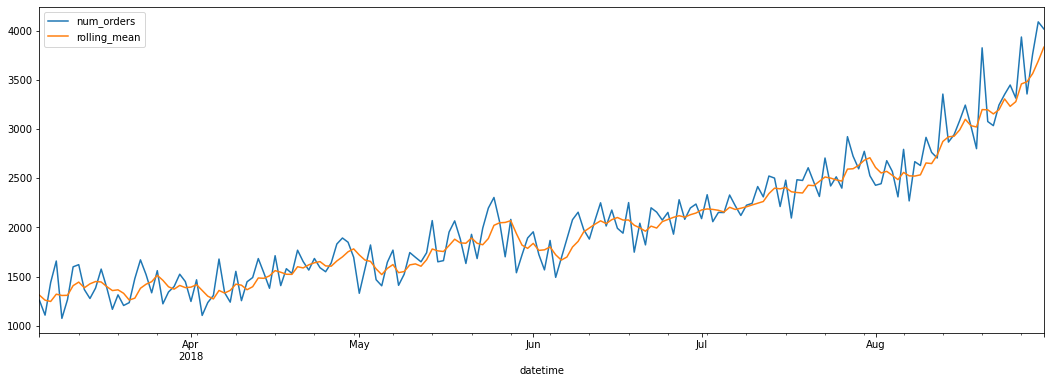

In [20]:
df_new[['num_orders', 'rolling_mean']].plot(figsize=(18, 6))
plt.show()

График стал более читабелен и из него можно сделать вывод, что присутствует тренд на увеличение количества заказов такси от месяца к месяцу.

- Фактор месяца исходя из общего тренда играет роль, так как месяцы лета имеют тренд более высокого роста относительно весенних
- Фактор дня играет также роль, так как имеет тенденцию также относительно месяца расти с течением времени
- Фактор дня недели играет одну из самых важных ролей, потому что данные исходя из него сильно варьируются
- Фактор часа играет самую важную роль, так как у нас прогнозирование на час вперед также на его фоне выделили сезонность ,где есть очень важные часы пиков и минимумов
- Фактор lag нужен для определения интервала на котором обучается модель из целевого признака исходя из желаемого горизонта (если ресэмпл на день, а прогноз строим на неделю вперед ,то lag(7)) в нашем случае прогноз на час вперед ,то берем и lag(1)
- Фактор rolling - это в чем-то схожий признак с lag, но как агрегирующая его функция также полезная для прогнозирования 

Исходя из графиков определеям какие календарные признаки будем закладывать в модель:

- Месяц и число (по графику тренда)
- Часы (по графику сезонности)
- День недели (по графику остатков)
- Мы делаем прогноз на сутки, поэтому скользящее среднее равно 24 часам

Добавим также:

Отстающие значения;<br/>
Скользящее среднее;

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['hour'] = data_new.index.hour
    data_new['dayofweek'] = data_new.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop('num_orders',axis=1)
    features_test = test.drop('num_orders',axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
    print(f'RSME = {rsme.round(2)} при lag = {max_lag}')
    return data_new

In [22]:
lags_list=[1,3,6,12,24]
data_temp =[]
df_new = df.copy()
for i in range(len(lags_list)):
    data_temp.append(make_features(df_new, lags_list[i], 24))
    display(data_temp[i].head())

RSME = 31.54 при lag = 1


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN


RSME = 31.46 при lag = 3


,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,NaN


RSME = 31.48 при lag = 6


,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN


RSME = 31.36 при lag = 12


,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 26.94 при lag = 24


,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Минимальное значение RSME при lag = 24, используем это значение параметра для дальнейшего исследования.

In [23]:
train, test = train_test_split(data_temp[4], shuffle=False, test_size=0.1)
train = train.dropna()
    
X_train = train.drop('num_orders',axis=1)
X_test = test.drop('num_orders',axis=1)
y_train = train['num_orders']
y_test = test['num_orders']
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3950, 29) (442, 29) (3950,) (442,)


## Обучение

In [24]:
res=[]
res_test=[]

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV.
Параметры моделей заранее подобраны таким образом, чтобы время обучения было минимальным при рассчитанной минимальной RSME. Для сокращения времени проверки кода, в графе подбор параметров уже указаны лучшие варианты из найденных

Начинаем с метода <b>Дерево решений</b>:

### DecisionTreeRegressor

In [25]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(20,30)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-dt_model.best_score_} при параметрах {dt_model.best_params_}')
res.append([(-dt_model.best_score_), dt_model.best_params_])

Лучшая RMSE: 28.776013240838164 при параметрах {'max_depth': 15, 'min_samples_leaf': 27}


### RandomForestRegressor

In [26]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
gb_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-gb_model.best_score_} при параметрах ,{gb_model.best_params_}')
res.append([(-gb_model.best_score_), gb_model.best_params_])

Лучшая RMSE: 25.341293665655318 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}


### GradientBoostingRegressor

In [27]:
model_gb = GradientBoostingRegressor()
param_grid = {
        'n_estimators' : range(80, 81, 1),
        'max_depth' : range(5, 6, 1),
        'verbose' : [0],
        'random_state' : [12345] 
        }

gsearch = GridSearchCV(model_gb, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-rf_model.best_score_} при параметрах ,{rf_model.best_params_}')
res.append([(-rf_model.best_score_), rf_model.best_params_])

Лучшая RMSE: 25.276206501024443 при параметрах ,{'max_depth': 5, 'n_estimators': 80, 'random_state': 12345, 'verbose': 0}


###  LightGBMRegressor

In [28]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=2)

param_grid = {
    "max_depth" : range(11,12),
    "n_estimators" : range(56,57)
}

gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
lgb_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-lgb_model.best_score_} при параметрах ,{lgb_model.best_params_}')
res.append([(-lgb_model.best_score_), lgb_model.best_params_])

Лучшая RMSE: 24.87613969873619 при параметрах ,{'max_depth': 11, 'n_estimators': 56}


### CatBoostRegressor

In [29]:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE)

param_grid = {
    "n_estimators": [500],
    'depth': [5]
}

gsearch = GridSearchCV(model_catboost, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
catboost_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-catboost_model.best_score_} при параметрах ,{catboost_model.best_params_}')
res.append([(-catboost_model.best_score_), catboost_model.best_params_])

Learning rate set to 0.06736
0:	learn: 28.7658450	total: 49.6ms	remaining: 24.8s
1:	learn: 27.9122652	total: 52ms	remaining: 12.9s
2:	learn: 27.0877245	total: 54.1ms	remaining: 8.96s
3:	learn: 26.3808759	total: 56.2ms	remaining: 6.97s
4:	learn: 25.7316554	total: 58.7ms	remaining: 5.81s
5:	learn: 25.1020499	total: 61.1ms	remaining: 5.03s
6:	learn: 24.5679022	total: 63.4ms	remaining: 4.46s
7:	learn: 24.0418377	total: 65.7ms	remaining: 4.04s
8:	learn: 23.5497872	total: 67.7ms	remaining: 3.69s
9:	learn: 23.1184451	total: 70ms	remaining: 3.43s
10:	learn: 22.7178259	total: 72.4ms	remaining: 3.22s
11:	learn: 22.3592845	total: 75.5ms	remaining: 3.07s
12:	learn: 21.9978920	total: 78.6ms	remaining: 2.94s
13:	learn: 21.6445955	total: 80.8ms	remaining: 2.8s
14:	learn: 21.2671784	total: 82.9ms	remaining: 2.68s
15:	learn: 20.9707688	total: 85.1ms	remaining: 2.57s
16:	learn: 20.7122763	total: 87.9ms	remaining: 2.5s
17:	learn: 20.4597914	total: 91.5ms	remaining: 2.45s
18:	learn: 20.1619221	total: 95ms

Cравним RSME, проведя кроссвалидацию на обучающей выборке по каждой из рассматриваемых моделей:

In [30]:
result = pd.DataFrame(data=res, columns=['rmse', 'optimal_parameters']).rename(index={0: 'DecisionTree', 1: 'RandomForest', 2: 'GradientBoosting', 3: 'LightGBM', 4: 'CatBoost'})
display(result)

,rmse,optimal_parameters
DecisionTree,28.776013,"{'max_depth': 15, 'min_samples_leaf': 27}"
RandomForest,25.341294,"{'max_depth': 15, 'min_samples_leaf': 2}"
GradientBoosting,25.276207,"{'max_depth': 5, 'n_estimators': 80, 'random_s..."
LightGBM,24.876140,"{'max_depth': 11, 'n_estimators': 56}"
CatBoost,24.511185,"{'depth': 5, 'n_estimators': 500}"


Таким образом мы получили минимальную метрику RSME = 24.511 при обучении модели методом CatBoost.

## Тестирование

Проведем финальное тестирование, и определим подходит ли полученный RSME под критерии заказчика.
В качестве лучшей модели будем использовать CatBoostRegressor c параметрами{'depth': 5, 'n_estimators': 500}

In [31]:
def importance(model,features):
    features = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(20, 20))
    plt.title('Важность признаков')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

In [32]:
start = time.time()
best_model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, depth=5, n_estimators=500)
best_model_catboost.fit(X_train, y_train)
end = time.time()
time_catboost = round(end-start,2)

In [33]:
start = time.time()
predict_catboost = best_model_catboost.predict(X_test)
end = time.time()
time_catboost_predict = round(end-start,2)

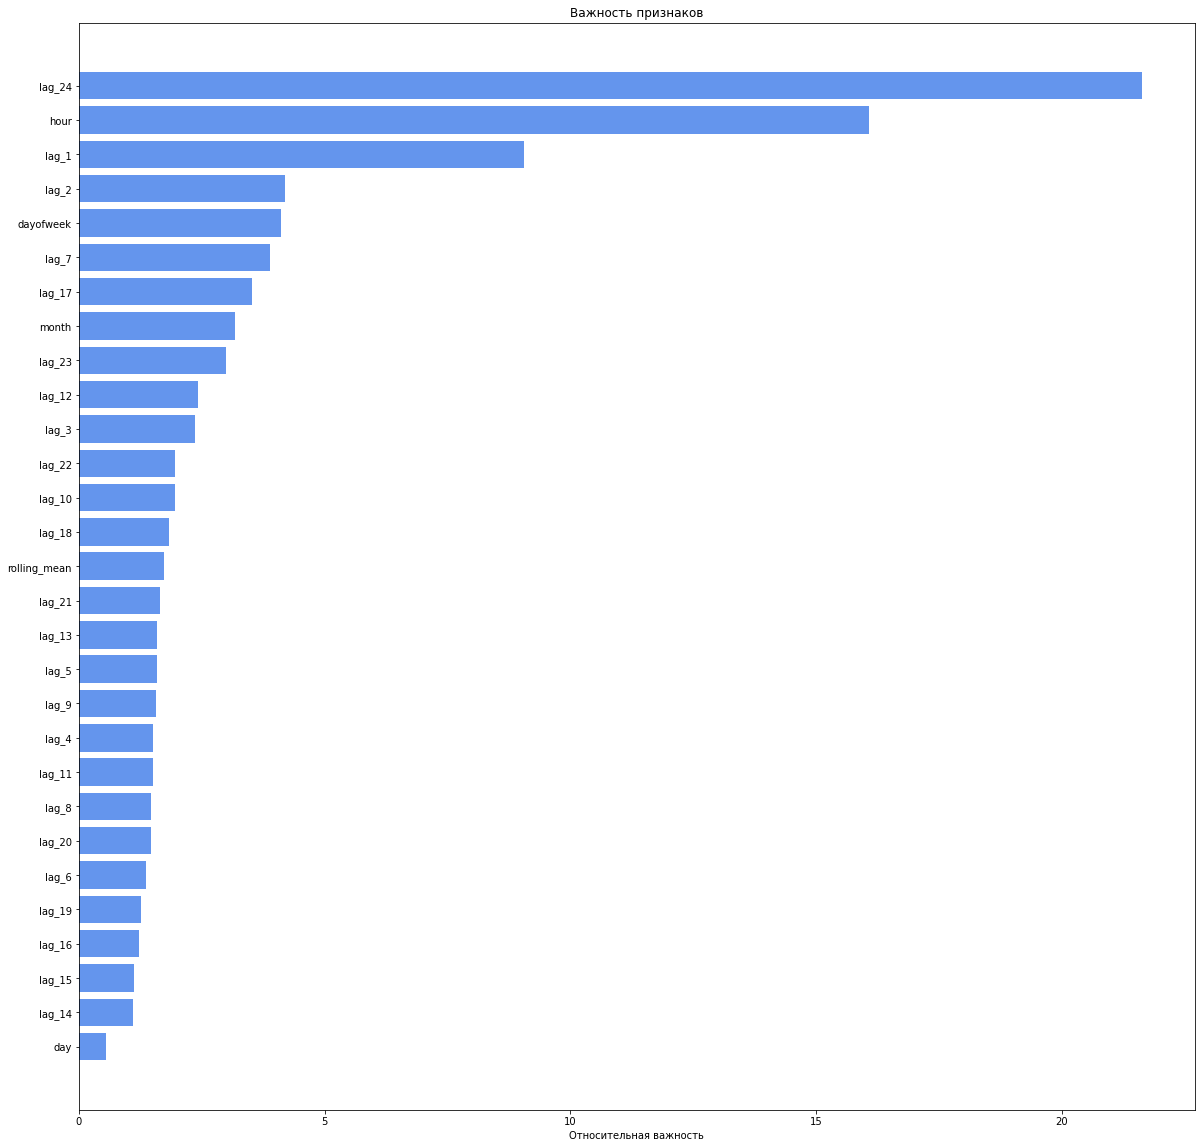

,Относительная важность
lag_24,21.619328
hour,16.076610
lag_1,9.066780
lag_2,4.188479
dayofweek,4.121874
lag_7,3.882910
lag_17,3.524888
month,3.186616
lag_23,3.003138
lag_12,2.431597


In [34]:
importance(best_model_catboost, X_test)

In [35]:
catboost_best_rmse = mean_squared_error(y_test, predict_catboost,squared = False)
print('RMSE модели CatBoostRegressor равна:', catboost_best_rmse.round(2))

RMSE модели CatBoostRegressor равна: 40.71


In [36]:
model_scores = pd.DataFrame(data=[
            ('СatBoostRegressor', -catboost_model.best_score_, catboost_best_rmse, time_catboost, time_catboost_predict)], 
            columns=['Рекомендуемая модель', 'RMSE на обучающей выборке', 'RMSE на тестовой выборке', 'Скорость обучения, сек', 'Скорость предсказания, сек'])
model_scores = model_scores.style.hide_index()
model_scores  

Рекомендуемая модель,RMSE на обучающей выборке,RMSE на тестовой выборке,"Скорость обучения, сек","Скорость предсказания, сек"
СatBoostRegressor,24.511185,40.714756,3.470000,0.010000


Визуализируем предскания по лучшей модели.

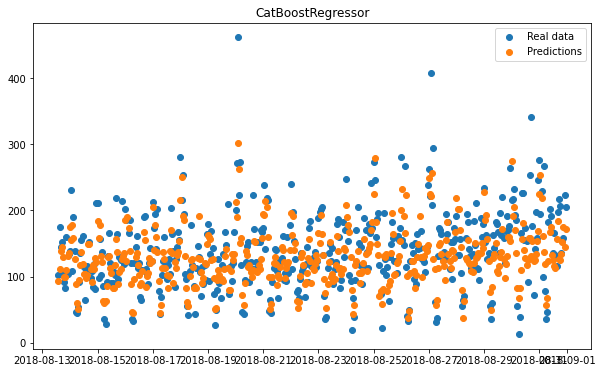

In [37]:
prediction_list = [predict_catboost]
model_list = ['CatBoostRegressor']
for pred in range(1):
    plt.figure(figsize=(10, 6)) 
    plt.scatter(y=y_test, x=y_test.index, label='Real data')
    plt.scatter(y=prediction_list[pred], x=y_test.index, label='Predictions')
    plt.legend(loc='upper right')
    plt.title(model_list[pred])
    plt.show()

В ходе проекта были обработаны данные о заказах такси.

Для прогноза количества заказов такси были построены 5 моделей предсказания.
Самой эффективной моделью, которая показала минимальную метрику RSME(**40,71**) является модель градиентного бустинга библиотеки **CatBoost** c параметрами **{'depth': 5, 'n_estimators': 500}**, о чем свидетельствует финальный график, на котором точки предсказание и реальных данных хорошо расположены очень близко друг к другу. 

Важными для модели признаками оказались 
- **lag_24**, 
- **hour**, 
- **lag_1**, <br/>

как и предсказывалось в первичном анализе. 

Требование о значении метрики RMSE (не более 48) выполнено.